In [120]:
### Loading libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load prophet components
from prophet import Prophet
from prophet.plot import plot_components, add_changepoints_to_plot
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric


import plotly.offline as py
from prophet.plot import (
plot_plotly,
plot_components_plotly,
plot_forecast_component_plotly,
plot_seasonality_plotly
)

import json
from prophet.serialize import model_to_json, model_from_json

In [121]:
# Loading dataset
df_hourly = pd.read_csv("bicycle_counts.csv")
df_hourly.head()

,Date,Fremont Bridge Total,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
0,2012-10-03T00:00:00.000,13.0,4.0,9.0
1,2012-10-03T01:00:00.000,10.0,4.0,6.0
2,2012-10-03T02:00:00.000,2.0,1.0,1.0
3,2012-10-03T03:00:00.000,5.0,2.0,3.0
4,2012-10-03T04:00:00.000,7.0,6.0,1.0


In [122]:
df_hourly.size

248160

In [123]:
# changing to datetime
df_hourly["Date"] = pd.to_datetime(df_hourly["Date"])
df_hourly.rename(columns= {"Date":"ds", "Fremont Bridge Total": "y"}, inplace = True)
df_hourly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62040 entries, 0 to 62039
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   ds                            62040 non-null  datetime64[ns]
 1   y                             62030 non-null  float64       
 2   Fremont Bridge East Sidewalk  62030 non-null  float64       
 3   Fremont Bridge West Sidewalk  62030 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.9 MB


In [124]:
# Converting from hourly to daily
df_daily = df_hourly.resample('24H', on = 'ds').sum()
df_daily.reset_index(inplace = True)
df_daily.head()

,ds,y,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
0,2012-10-03,3521.0,1760.0,1761.0
1,2012-10-04,3475.0,1708.0,1767.0
2,2012-10-05,3148.0,1558.0,1590.0
3,2012-10-06,2006.0,1080.0,926.0
4,2012-10-07,2142.0,1191.0,951.0


In [125]:
df_daily.shape

(2585, 4)

In [126]:
# Converting from hourly to daily
df_weekly = df_hourly.resample('W', on = 'ds').sum()
df_weekly.reset_index(inplace = True)
df_weekly.head()

,ds,y,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
0,2012-10-07,14292.0,7297.0,6995.0
1,2012-10-14,16795.0,8679.0,8116.0
2,2012-10-21,15509.0,7946.0,7563.0
3,2012-10-28,13437.0,6901.0,6536.0
4,2012-11-04,12194.0,6408.0,5786.0


In [127]:
df_weekly.shape

(370, 4)

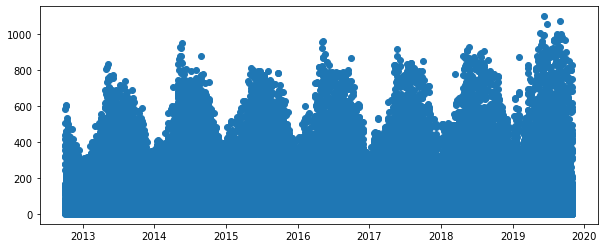

In [128]:
# Hourly plot
fig, ax = plt.subplots(figsize = (10, 4))
ax.scatter(df_hourly["ds"], df_hourly["y"])
plt.show()

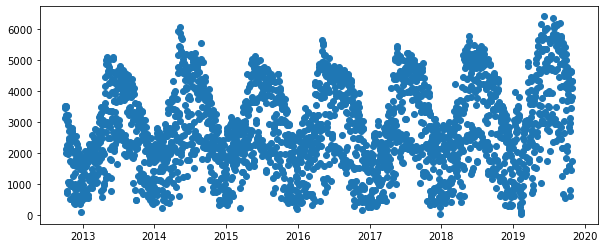

In [129]:
# Daily plot
fig, ax = plt.subplots(figsize = (10, 4))
ax.scatter(df_daily["ds"], df_daily["y"])
plt.show()

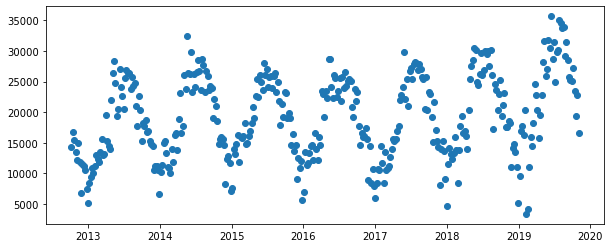

In [130]:
# Weekly plot
fig, ax = plt.subplots(figsize = (10, 4))
ax.scatter(df_weekly["ds"], df_weekly["y"])
plt.show()

# Building daily forecast

### Adding holidays

In [131]:
from prophet.make_holidays import make_holidays_df

year_list = df_daily['ds'].dt.year.unique().tolist()

# Identify the final year, as an integer, and increase it by 2
year_list.append(year_list[-1] + 2)
holidays = make_holidays_df(year_list = year_list,
                            country = 'US',
                            state = 'WA')

### Training model

22:22:19 - cmdstanpy - INFO - Chain [1] start processing
22:22:20 - cmdstanpy - INFO - Chain [1] done processing


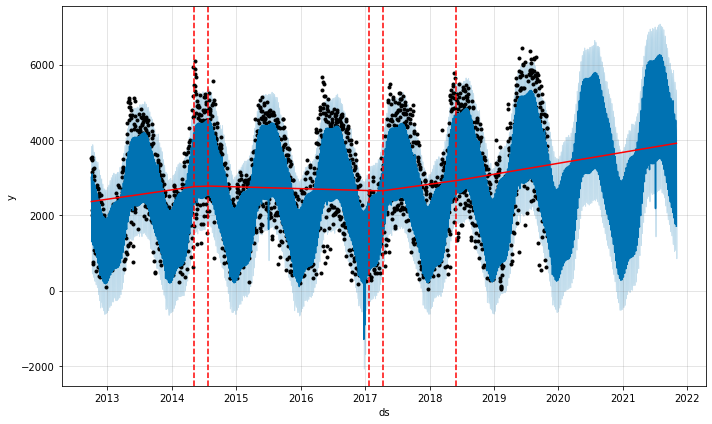

In [139]:
model = Prophet(seasonality_mode = 'multiplicative',
                yearly_seasonality = 4,
                holidays = holidays)

model.fit(df_daily) # on daily dataset
future = model.make_future_dataframe(periods = 365 * 2, freq = "D") # Frequency Daily
forecast = model.predict(future)
fig = model.plot(forecast)
add_changepoints_to_plot(fig.gca(), model, forecast)
plt.show()

In [140]:
# Saving figure
fig.savefig("forecastplot.png", dpi = 400, bbox_inches = "tight")

In [141]:
fig = plot_plotly(model, forecast, trend = True, changepoints = True)
py.iplot(fig)

### Model saving and loading

In [142]:
with open('Seattle_bicycle_count_model.json', 'w') as file_out:
    json.dump(model_to_json(model), file_out)

In [143]:
with open('Seattle_bicycle_count_model.json', 'r') as file_in:
    model = model_from_json(json.load(file_in))

d:\Miniconda\envs\datascience\lib\site-packages\prophet\serialize.py:156: FutureWarning:

The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')



##### Component plot

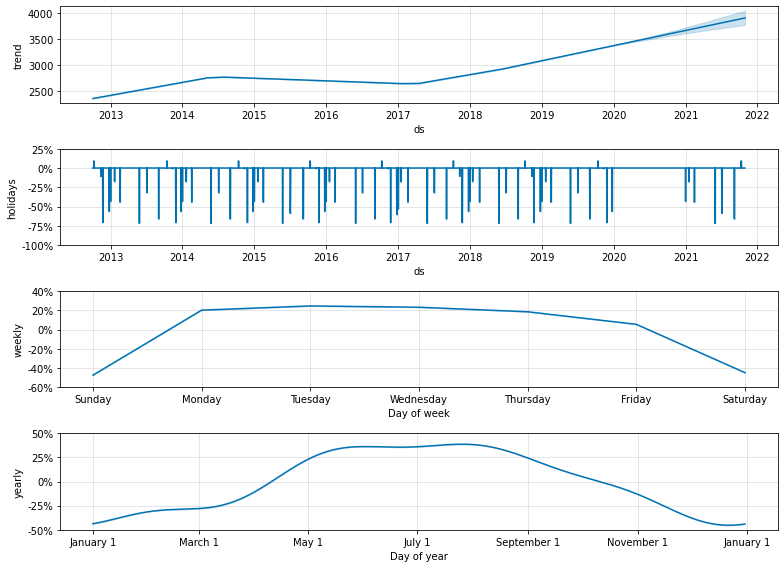

In [151]:
fig2 = model.plot_components(forecast, figsize = (11, 8))
# or fig2 = plot_components(model, forecast)
plt.show()

In [152]:
# Saving figure
fig2.savefig("components_plot.png", dpi = 400, bbox_inches = "tight")

In [ ]:
fig = plot_components_plotly(model,
                             forecast,
                             figsize = (800, 175))
py.iplot(fig)

### Cross validation

In [ ]:
df_cv = cross_validation(model, 
                        horizon = '90 days',     # forecast period
                        period = '30 days',      # 
                        initial = '730 days',    # Initial days
                        parallel = 'processes')  # Parellel processing

df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2014-10-28,3251.487028,2548.671878,4024.873809,2261.0,2014-10-27
1,2014-10-29,3159.373361,2383.237760,3935.526361,3396.0,2014-10-27
2,2014-10-30,2985.167005,2286.890180,3735.737163,2392.0,2014-10-27
3,2014-10-31,2646.248763,1893.350488,3385.657918,1938.0,2014-10-27
4,2014-11-01,1251.696543,535.185060,1963.060484,1294.0,2014-10-27


### Calculating model performance metric

In [ ]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,9 days,498517.508827,706.057723,543.831697,0.481232,0.162258,0.260536,0.757062
1,10 days,512327.003218,715.770217,551.001358,0.488503,0.166228,0.265368,0.753296
2,11 days,486800.501809,697.710901,541.547055,0.465511,0.164080,0.259890,0.758945
3,12 days,493403.933955,702.427173,547.403289,0.458065,0.164074,0.258994,0.745763
4,13 days,483703.688662,695.488094,539.234179,0.452523,0.160024,0.252911,0.753296


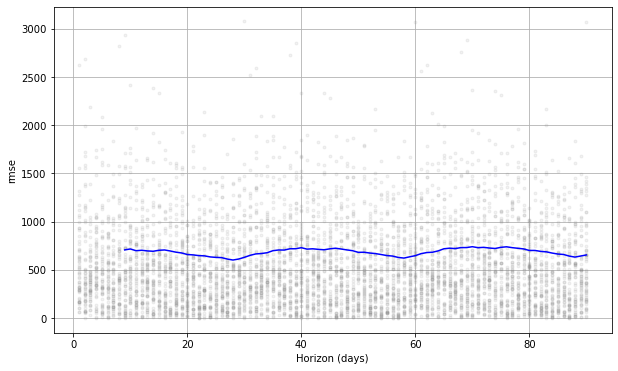

In [153]:
# Showing cross validation metric plot
fig = plot_cross_validation_metric(df_cv,
                                   metric = 'rmse',
                                   rolling_window = 0.1)
plt.show()

In [154]:
# Saving figure
fig.savefig("cross_validation_plot.png", dpi = 400, bbox_inches = "tight")